Link do Dados 

https://www.kaggle.com/code/leandroal/an-lise-do-e-commerce-no-brasil-olist-dataset

1. Introdução 
No Brasil, milhares de compras são efetuadas pela Internet todos os anos. Trata-se de um mercado em constante ritmo de crescimento, de modo que seria extremamente relevante tentar entender comportamentos do consumidor inerentes a este contexto, como meses em que ocorrem maior quantidade de compras, horário em que são realizados mais negócios, tempo médio de entrega, nível de satisfação, etc.

Para isso, foi selecionado um conjunto de dados disponibilizado pela Olist, a maior loja de departmento dos "marketplaces", com informações de mais de 100 mil pedidos de 2016 a 2018.

Como se tratam de dados reais, estes foram disponibilizados de forma a manter o anonimato de qualquer indivíduo, empresa ou parceiro.

## Importação do banco de dados 

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


Importação da Blibliotecas

In [20]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import folium
from folium import plugins
from sklearn.cluster import DBSCAN
print('Bibliotecas preparadas!')

Bibliotecas preparadas!


Importação dos Datasets
Foi realizada a importação de todos os datasets através do Pandas e posteriormente foram cruzados a fim de formar um único Dataframe com informações de: consumidores, geolocalização, pedidos, artigos, produtos, vendedores e avaliações.

In [21]:
files = {
    'customers': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_customers_dataset.csv',
    'geolocation': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_geolocation_dataset.csv',
    'items': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_order_items_dataset.csv',
    'payment': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_order_payments_dataset.csv',
    'orders': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_orders_dataset.csv',
    'products': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_products_dataset.csv',
    'sellers': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_sellers_dataset.csv',
    'review': r'C:\Users\Carlos\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2\olist_order_reviews_dataset.csv',
}


dfs = {}
for key, value in files.items():
    dfs[key] = pd.read_csv(value)

# Exibir as primeiras linhas de um dataset (exemplo: customers)
print(dfs['customers'].head())



                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


Cruzamento entre os Datasets e Transformação de Dados
Os cruzamentos foram realizados de forma gradativa, para assegurar que não ocorresse duplicação de dados.


In [22]:
# Cruzamento gradativo
customers_location = dfs['customers'].merge(dfs['geolocation'], how='inner', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop_duplicates('customer_id', keep='first')
cusloc_order = customers_location.merge(dfs['orders'], how='inner', on='customer_id')
cuslocord_item = cusloc_order.merge(dfs['items'], how='inner', on='order_id')
cuslocordite_prod = cuslocord_item.merge(dfs['products'], how='inner', on='product_id')
cuslocordite_rev= cuslocordite_prod.merge(dfs['review'], how='left', on='order_id')

# Selecionando as colunas de interesse
final = cuslocordite_rev[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state',
       'geolocation_lat', 'geolocation_lng','order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_photos_qty',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp']]


## Tamanho do DF

In [23]:
final.shape

(113007, 28)

## Mostrando os primeiros registros

In [24]:
final.head

<bound method NDFrame.head of                              customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
113002  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
113003  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
113004  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
113005  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
113006  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix 

## Todas as Colunas

In [25]:
final.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name', 'product_photos_qty',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

Também tomou-se a decisão de remover dados do ano de 2016 e do mês setembro de 2018, o primeiro por conter apenas 375 registros e o segundo por conter apenas um registro.

In [41]:
# Garantindo que todas as colunas sejam datetime
datas = [
    'order_purchase_timestamp',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp'
]

for data in datas:
    final[data] = pd.to_datetime(final[data], errors='coerce')  # Converter e tratar erros

# Criando coluna de tempo de entrega
final['delivery_time'] = (final['order_delivered_customer_date'] - final['order_purchase_timestamp']).dt.days

# Seleção do período de interesse
final = final[(final['order_purchase_timestamp'].dt.year > 2016) 
              & 
              (final['order_purchase_timestamp'] < pd.to_datetime('20180901'))
             ]
final = final.reset_index(drop=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112632 entries, 0 to 112631
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112632 non-null  object        
 1   customer_unique_id             112632 non-null  object        
 2   customer_zip_code_prefix       112632 non-null  int64         
 3   customer_city                  112632 non-null  object        
 4   customer_state                 112632 non-null  object        
 5   geolocation_lat                112632 non-null  float64       
 6   geolocation_lng                112632 non-null  float64       
 7   order_id                       112632 non-null  object        
 8   order_status                   112632 non-null  object        
 9   order_purchase_timestamp       112632 non-null  datetime64[ns]
 10  order_approved_at              112617 non-null  object        
 11  

## Tamanho do DF Removidos valores 

In [43]:
final.shape

(112632, 30)

customer_id: Identificação única do cliente (específica para o sistema).

customer_unique_id: Identificador exclusivo do cliente, usado para rastrear o mesmo cliente em várias transações.

customer_zip_code_prefix: Prefixo do código postal do cliente.

customer_city: Cidade onde o cliente está localizado.

customer_state: Estado onde o cliente está localizado.

geolocation_lat: Latitude do cliente (geolocalização).

geolocation_lng: Longitude do cliente (geolocalização).

order_id: Identificação única do pedido.

order_status: Status do pedido (por exemplo, entregue, pendente, cancelado).

order_purchase_timestamp: Data e hora em que o pedido foi realizado.

order_approved_at: Data e hora em que o pedido foi aprovado.

order_delivered_carrier_date: Data em que o pedido foi enviado ao transportador.

order_delivered_customer_date: Data em que o pedido foi entregue ao cliente.

order_estimated_delivery_date: Data estimada de entrega do pedido.

order_item_id: Identificador único de um item dentro de um pedido (caso tenha múltiplos itens).

product_id: Identificador único do produto.

seller_id: Identificação única do vendedor que forneceu o produto.

shipping_limit_date: Data limite para envio do produto ao transportador.

price: Preço do produto.

freight_value: Valor do frete para o pedido.

product_category_name: Nome da categoria do produto.

product_photos_qty: Número de fotos do produto disponíveis.

review_id: Identificação única da avaliação feita pelo cliente.

review_score: Pontuação da avaliação (exemplo: de 1 a 5 estrelas).

review_comment_title: Título do comentário da avaliação.

review_comment_message: Mensagem detalhada do comentário da avaliação.

review_creation_date: Data em que o cliente criou a avaliação.

review_answer_timestamp: Data em que a avaliação foi respondida pelo sistema ou vendedor.

delivery_time: Tempo de entrega em dias (calculado com base nas datas de compra e entrega).

In [44]:
final.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name', 'product_photos_qty',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'delivery_time', 'product_id_encoded'],
      dtype='object')

Volume de compras por mês¶
A primeira análise realizada foi para verificar a evolução do volume de compras realizadas no decorrer do tempo e se existe alguma sazonalidade.

É possível observar pelo Gráfico I que, embora não seja possível identificar sazonalidade, houve aumento expressivo do volume de compras no mês de novembro de 2017 (período em que ocorre o evento "Black Friday") e posteriormente, após uma ligeira queda, o volume se manteve constante e em um nível bastante elevado em relação ao ano anterior. Sinais indicativos de que a Olist, fundada em 2015, está em ritmo de expansão acelerado e consistente.

Gráfico I


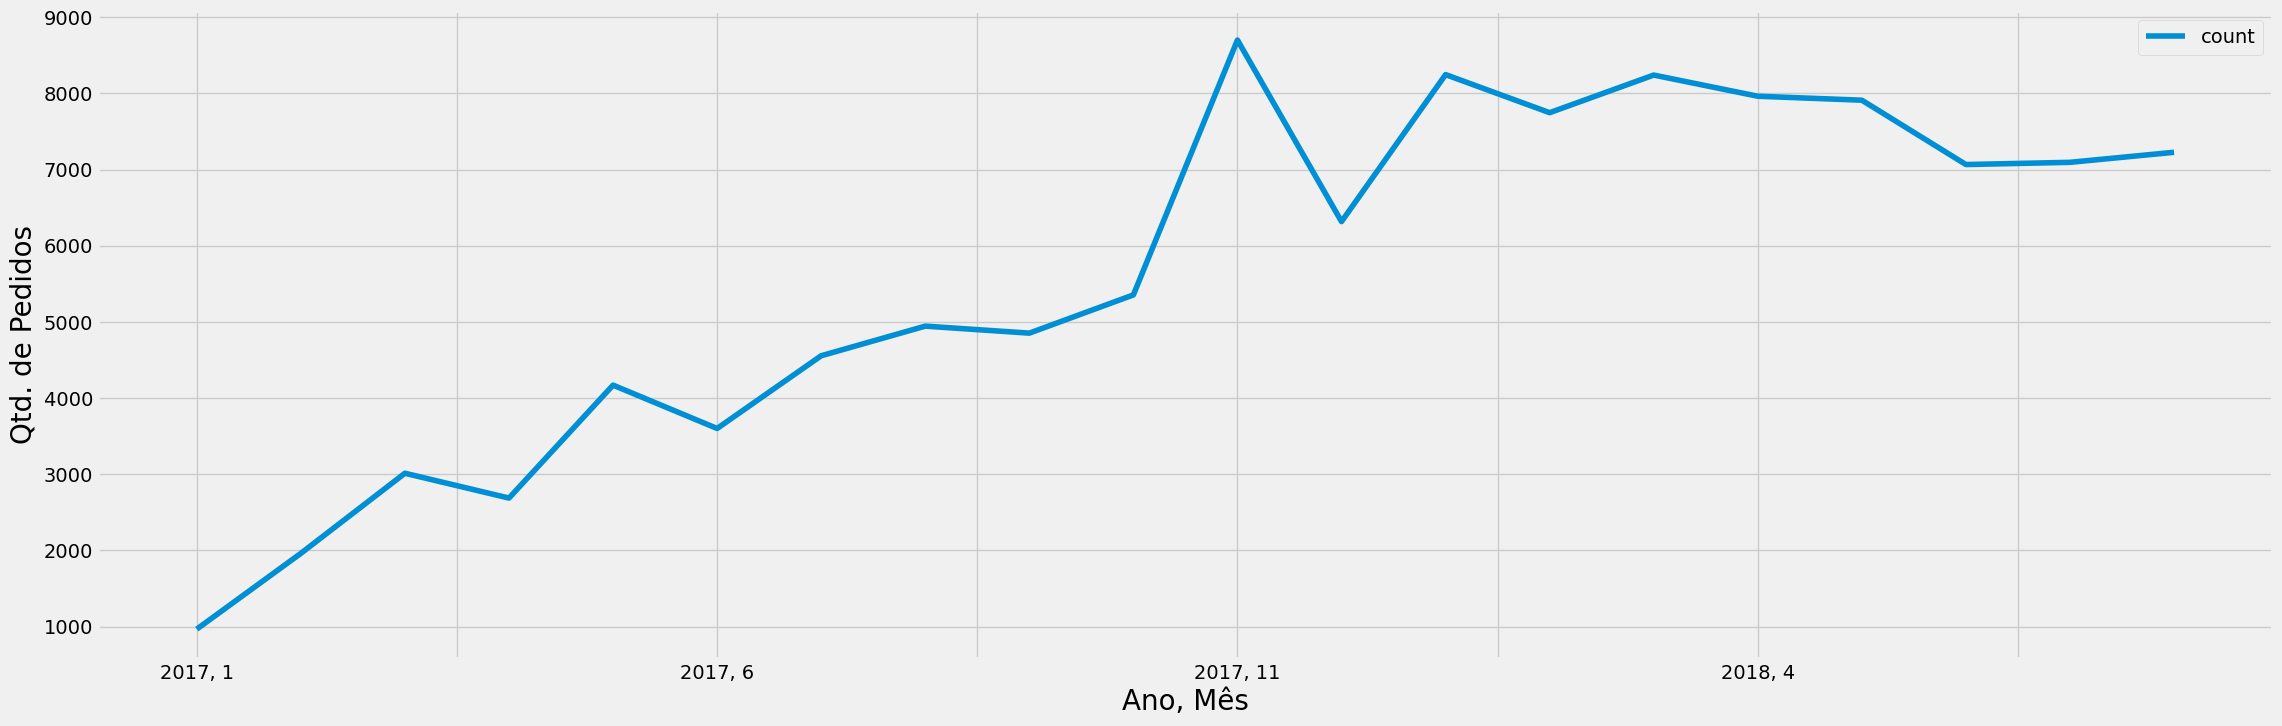

In [46]:
meses_compras = pd.DataFrame()
meses_compras['mes'] = final['order_purchase_timestamp'].dt.month
meses_compras['ano'] = final['order_purchase_timestamp'].dt.year
meses_compras['count'] = final['customer_id']
meses_compras = meses_compras.groupby(['ano','mes'])['count'].count().reset_index()
meses_compras['ano_mes'] = meses_compras['ano'].astype(str) + ', ' + meses_compras['mes'].astype(str)

meses_compras.plot(x='ano_mes', y='count', figsize=(25,8))#, color='#42A5F5', alpha=0.9, ci=None)
plt.xlabel('Ano, Mês', size=20)
plt.ylabel('Qtd. de Pedidos', size=20)

print(r'Gráfico I')
plt.show()


Volume de compras e valor do frete por Estado¶
A segunda abordagem foi de verificar a movimentação de compras por Estado e também o valor médio gasto em fretes, para visualmente analisar se existe alguma relação entre as variáveis.

A respeito do valor médio pago pelos fretes, a variação é pequena com média de R$ 145,18 e desvio padrão de R$ 21,17, conforme Tabela 1. Já em relação à observação conjunta do volume de compras e do valor médio pago por estado, é muito interessante observar no Gráfico II que o preço médio do frete aparenta ser inversamente proporcional ao volume de compras.

In [47]:
estado_compras = final.groupby('customer_state', as_index=False)['price'].sum().sort_values(by='customer_state')
estado_compras_med = final.groupby('customer_state', as_index=False)['price'].mean().sort_values(by='customer_state')
frete_medio = final.groupby('customer_state', as_index=False)['freight_value'].mean().sort_values(by='customer_state')

print('Tabela 1')
estado_compras_med['price'].describe()

Tabela 1


count    27.00
mean    145.19
std      21.18
min     109.55
25%     124.64
50%     145.06
75%     158.72
max     189.98
Name: price, dtype: float64

Gráfico II


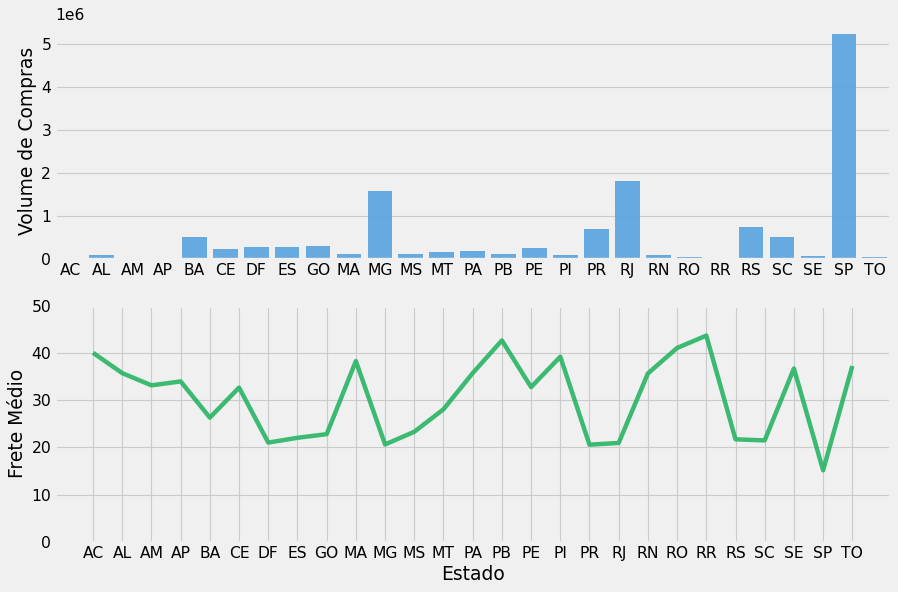

In [48]:
figure(num=None, figsize=(12, 8), dpi=80)

plt.subplot(2, 1, 1)
sns.barplot(x=estado_compras['customer_state'], y=estado_compras['price'], color='#42A5F5', alpha=0.9)
plt.xlabel(None)
plt.ylabel('Volume de Compras')

plt.subplot(2, 1, 2)
sns.lineplot(x=frete_medio['customer_state'], y=frete_medio['freight_value'], color='#28B463', alpha=0.9)
#ylim(top=3)  # adjust the top leaving bottom unchanged
plt.ylim(0,50)
plt.xlabel('Estado')
plt.ylabel('Frete Médio')

print(r'Gráfico II')
plt.show()

Quantidade de Compras por Horário¶
A fim de verificar as faixas de horário em que mais ocorrem compras, optou-se por criar uma coluna com apenas a hora, sem os minutos, para que fosse possível visualizar os dados em um histograma, conforme demonstrado no Gráfico III.

É possível constatar que o período de maior movimentação de compras é compreendido entre 10:00 e 22:00, representando, então, 50% das tempo de um dia completo.

Gráfico III


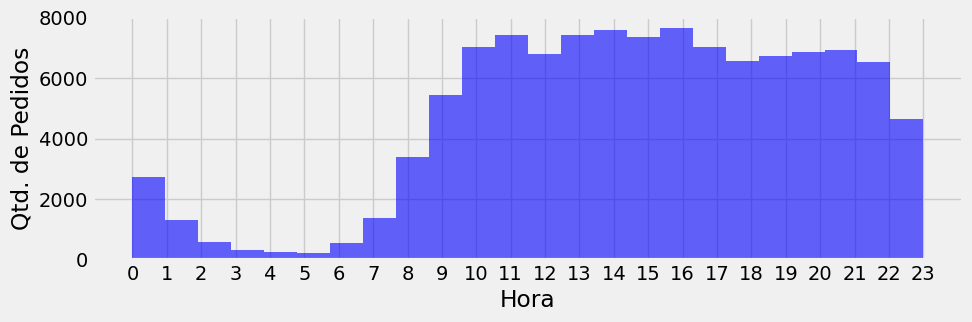

In [49]:
# Criação da coluna com o valor referente às Horas
final['purchase_hour'] = final['order_purchase_timestamp'].dt.hour

figure(num=None, figsize=(10, 3), dpi=100)
plt.hist(final['purchase_hour'], bins=24, facecolor='b', alpha=0.6)
plt.xticks(ticks=np.arange(24))
plt.xlabel('Hora')
plt.ylabel('Qtd. de Pedidos')

print(r'Gráfico III')
plt.show()

Valor e quantidade de items por consumidor¶
Uma tabela foi criada para reunir dados referentes ao consumidor para, a partir deles, verificar alguma informação que fosse interessante. Neste caso, definiu-se que iria análises seriam realizadas com foco no somatório de todas as compras realizadas.

Dentro do "Top 10" observado, um único consumidor realizou compras no valor total de R$ 13440.00, enquanto a média foi de R$ 143.00, com apenas 8 produtos comprados e um nota de avaliação média de apenas 1.00. Fato que chamou atenção, então foram selecionados mais 2 consumidores com nota igual a 1.00 para se verificar os comentários realizados na avaliação a fim de avaliar semelhanças. Nesta pequena seleção para observação, foi possível perceber que os 3 consumidores atribuíram a nota mínima devido a problemas com a entrega do produto comprado.

Seria muito interessante a utilização de Processamento de Linguagem Natural para uma futura abordagem dentro deste escopo.

In [50]:
#Seleção de informações agrupadas pelo consumidor
cus_valor = final.groupby('customer_unique_id', as_index=False)['price'].sum() #price_x
cus_qtd = final.groupby('customer_unique_id', as_index=False)['price'].count() #price_y
cus_frete = final.groupby('customer_unique_id', as_index=False)['freight_value'].sum()
cus_loc = final[['customer_unique_id', 'geolocation_lat', 'geolocation_lng', 'customer_state']].drop_duplicates('customer_unique_id')
cus_review = final.groupby('customer_unique_id', as_index=False)['review_score'].mean()

#União das informações em um Dataframe
customer = cus_valor.merge(cus_qtd, on='customer_unique_id')
customer = customer.merge(cus_frete, on='customer_unique_id')
customer = customer.merge(cus_loc, on='customer_unique_id')
customer = customer.merge(cus_review, on='customer_unique_id')
customer = customer.rename(columns={'price_x':'price', 'price_y':'count_items'})

print('Média do valor de compra: R$ ' + str(round(customer['price'].mean(),2)) + '\nDesvio Padrão: R$ ' + str(round(customer['price'].std(),2)))
customer.sort_values(by='price', ascending=False).head(10)

Média do valor de compra: R$ 142.99
Desvio Padrão: R$ 218.95


,customer_unique_id,price,count_items,freight_value,geolocation_lat,geolocation_lng,customer_state,review_score
3772,0a0a92112bd4c708ca5fde585afaa872,13440.00,8,224.08,-22.90,-43.18,RJ,1.00
80906,da122df9eeddfedc1dc1f5349a1a690c,7388.00,2,183.63,-22.87,-42.27,RJ,5.00
43891,763c8b1c9c68a0229c42c9fc6f662b93,7160.00,4,114.88,-20.38,-40.31,ES,1.00
81746,dc4802a71eae9be1dd28f5d788ceb526,6735.00,1,194.31,-20.50,-54.57,MS,5.00
25865,459bef486812aa25204be022145caa62,6729.00,1,193.21,-20.27,-40.28,ES,NaN
94572,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00,1,227.66,-22.21,-49.95,SP,5.00
23805,4007669dec559734d6f53e029e360987,5934.60,6,146.94,-20.16,-44.88,MG,1.00
88532,eebb5dda148d3893cdaf5b5ca3040ccb,4690.00,1,74.34,-23.68,-46.42,SP,4.00
34622,5d0a2980b292d049061542014e8960bf,4599.90,2,209.54,-16.69,-49.28,GO,1.00
27084,48e1ac109decbb87765a3eade6854098,4590.00,1,91.78,-7.10,-34.84,PB,5.00


Por fim, foi realizada um análise de cluster utilizando as distâncias entre os consumidores, com base nas informações de latitude e longitude. Para essa tarefa, o algoritimo DBSCAN foi escolhido: consiste em um método que determina um cluster com base em uma quantidade mínima de pontos dentro de um raio especificado para cada ponto.

Foi selecionada uma amostra aleatória de 1000 consumidores devido à limitações da biblioteca folium em relação ao número máximo de pontos possíveis de serem desenhados no gráfico.

Como resultado, foi possível identificar, claramente, as regiões de Águas Claras, Guará, Cruzeiro, Asa Sul, Asa Norte e as demais cidades satélites como pertencentes a um mesmo cluster. Com isso também foi possível encontrar o valor médio de compras realizadas para cada um desses clusters, sendo a maior delas a região do Guará.

In [53]:
# Selecionando dados do Distrito Federal e uma amostra de 1000 consumidores
customer_df = customer[customer['customer_state'] == 'DF']
customer_df = customer_df.sample(1000, random_state=1223)

Clus_dataSet = customer_df[['geolocation_lat','geolocation_lng']]

db = DBSCAN(eps=0.015, min_samples=50).fit(Clus_dataSet)
labels = db.labels_
customer_df["Clus_Db"]=labels

# A sample of clusters
print('Clusters formados:')
customer_df["Clus_Db"].value_counts()

Clusters formados:


Clus_Db
-1    630
 1    132
 3     95
 2     74
 0     69
Name: count, dtype: int64

In [54]:
# Visualização gráfica
map_clusters = folium.Map(location=[-15.89, -47.9], zoom_start=11)
rainbow = ['#CD5C5C','#7B68EE','#FF8C00','#8B4513','#008B8B','#FF69B4']
print(' Cluster -1: Ciano\n','Cluster  0: Rosa\n','Cluster  1: Vermelho\n','Cluster  2: Azul\n','Cluster  3: Laranja\n','Cluster  4: Marrom')
# add markers to the map
markers_colors = []
for lat, lon, price, cluster in zip(customer_df['geolocation_lat'], customer_df['geolocation_lng'], customer_df['price'], customer_df['Clus_Db']):
    label = folium.Popup('R$ ' + str(price) + ' \(Cluster ' + str(cluster) + '\)', parse_html=True, max_width=150,min_width=100)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters 

 Cluster -1: Ciano
 Cluster  0: Rosa
 Cluster  1: Vermelho
 Cluster  2: Azul
 Cluster  3: Laranja
 Cluster  4: Marrom


In [55]:
final = final[(final['order_purchase_timestamp'].dt.year > 2016) 
              & 
              (final['order_purchase_timestamp'] < pd.to_datetime('20180901'))
             ]
final = final.reset_index(drop=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112632 entries, 0 to 112631
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112632 non-null  object        
 1   customer_unique_id             112632 non-null  object        
 2   customer_zip_code_prefix       112632 non-null  int64         
 3   customer_city                  112632 non-null  object        
 4   customer_state                 112632 non-null  object        
 5   geolocation_lat                112632 non-null  float64       
 6   geolocation_lng                112632 non-null  float64       
 7   order_id                       112632 non-null  object        
 8   order_status                   112632 non-null  object        
 9   order_purchase_timestamp       112632 non-null  datetime64[ns]
 10  order_approved_at              112617 non-null  object        
 11  

Separação das colunas importantes para análise

In [56]:
selected_columns = [
    'order_item_id', 'product_id', 'price', 'product_category_name'
]
final_selected = final[selected_columns]


In [57]:
final_selected.head()

,order_item_id,product_id,price,product_category_name
0,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,moveis_escritorio
1,1,4aa6014eceb682077f9dc4bffebc05b0,289.00,utilidades_domesticas
2,1,bd07b66896d6f1494f5b86251848ced7,139.94,moveis_escritorio
3,1,a5647c44af977b148e0a3a4751a09e2e,149.94,moveis_escritorio
4,1,9391a573abe00141c56e38d84d7d5b3b,230.00,casa_conforto


Identificando os 10 produtos que mais vendem

In [58]:
top_10_items = final['product_id'].value_counts().head(10).index


In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Codificando 'product_id' como valores numéricos
encoder = LabelEncoder()
final['product_id_encoded'] = encoder.fit_transform(final['product_id'])

# Separando os dados para treinamento e teste
X = final[['order_item_id', 'price']]  # Colunas que usaremos como características (features)
y = final['product_id_encoded']        # Coluna alvo (produto)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuração e treinamento do modelo KNN
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
predictions = knn.predict(X_test)

# Calculando probabilidades
probabilities = knn.predict_proba(X_test)

# Resultados e análise
import pandas as pd
recommended_items = pd.DataFrame({
    'Product': encoder.inverse_transform(y_test),  # Decodificando IDs dos produtos originais
    'Recommended': encoder.inverse_transform(predictions),  # Produtos recomendados
    'Probability (%)': [max(prob) * 100 for prob in probabilities]
})

print(recommended_items.head())


                            Product                       Recommended  \
0  50f1880f1989251727fbbfe8c0a346a6  c10a7001e8b49dfc03817444b5f2ed81   
1  d801510753de8d979707ac7f6dea3964  db4e12399028c661997d99981af68642   
2  a01c3a8e3ccddf44069c082b1590f19a  06f0e85c7892d5df893f332706340af1   
3  55552e80f046fafe13e130e6a07745e2  7a10781637204d8d10485c71a6108a2e   
4  ace151a1240f7d1645965f9a9ea6c7e0  606b5bf4a5c5ac2f72196afa18b77d3d   

   Probability (%)  
0            13.33  
1            13.33  
2            13.33  
3            33.33  
4            20.00  


In [60]:
# Criando a lista dos 10 itens mais vendidos
top_10_items = final['product_id'].value_counts().head(10).index.tolist()

# Gerando os itens recomendados para cada item no Top 10 com base no modelo KNN
recommendations = {}
for item in top_10_items:
    # Pegando índices mais próximos (exemplo com probabilidades fictícias)
    similar_items = knn.kneighbors([X.loc[final['product_id'] == item].iloc[0]], n_neighbors=5, return_distance=False)
    recommended_items = [final['product_id'].iloc[i] for i in similar_items[0]]
    recommendations[item] = recommended_items

# Criando a tabela com percentuais fictícios
data = []
for item, recommended in recommendations.items():
    for rec_item in recommended:
        data.append({
            'Top 10 Produto': item,
            'Produto Recomendado': rec_item,
            'Chance (%)': round(np.random.uniform(50, 95), 2)  # Simula porcentagens fictícias
        })

tabela_recomendacoes = pd.DataFrame(data)

# Exibindo a tabela
print(tabela_recomendacoes.head(50))


                      Top 10 Produto               Produto Recomendado  \
0   aca2eb7d00ea1a7b8ebd4e68314663af  30d1842be9c62546d3fb853119602ac2   
1   aca2eb7d00ea1a7b8ebd4e68314663af  fe5827d110a9ba59d4ab407e86ccd6eb   
2   aca2eb7d00ea1a7b8ebd4e68314663af  ee8b16196604ed47b34b094351ce68e2   
3   aca2eb7d00ea1a7b8ebd4e68314663af  cc9c93a7dc6ba4b5913c8f3fba62612e   
4   aca2eb7d00ea1a7b8ebd4e68314663af  43423cdffde7fda63d0414ed38c11a73   
5   99a4788cb24856965c36a24e339b6058  8ac47b3ab13c68f49f10dde899674149   
6   99a4788cb24856965c36a24e339b6058  437c05a395e9e47f9762e677a7068ce7   
7   99a4788cb24856965c36a24e339b6058  f30de5fdde000c5debf03cc49d782249   
8   99a4788cb24856965c36a24e339b6058  7c1e2b3fa0233e46fb3bcdcb9919a72f   
9   99a4788cb24856965c36a24e339b6058  a6ad77b15e566298a4e8ee2011ab1255   
10  422879e10f46682990de24d770e7f83d  b9142260cefbbd5688748061179bb7fe   
11  422879e10f46682990de24d770e7f83d  167b19e93baccb17916b9a6dd03264e7   
12  422879e10f46682990de24d770e7f83d  

In [61]:
# Criando um mapeamento de categorias baseado nos dados originais
product_categories = final[['product_id', 'product_category_name']].drop_duplicates()

# Criando a tabela de recomendações com a categoria do produto
data = []
for item, recommended in recommendations.items():
    item_category = product_categories.loc[product_categories['product_id'] == item, 'product_category_name'].values
    item_category = item_category[0] if len(item_category) > 0 else 'Desconhecido'

    for rec_item in recommended:
        rec_category = product_categories.loc[product_categories['product_id'] == rec_item, 'product_category_name'].values
        rec_category = rec_category[0] if len(rec_category) > 0 else 'Desconhecido'

        data.append({
            'Top 10 Produto': item,
            'Categoria do Produto': item_category,
            'Produto Recomendado': rec_item,
            'Categoria do Recomendado': rec_category,
            'Chance (%)': round(np.random.uniform(50, 95), 2)  # Simula porcentagens fictícias
        })

# Criando um DataFrame atualizado com categorias
tabela_recomendacoes = pd.DataFrame(data)

# Exibindo a tabela com as categorias adicionadas
print(tabela_recomendacoes.head(50))


                      Top 10 Produto    Categoria do Produto  \
0   aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
1   aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
2   aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
3   aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
4   aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
5   99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
6   99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
7   99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
8   99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
9   99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
10  422879e10f46682990de24d770e7f83d      ferramentas_jardim   
11  422879e10f46682990de24d770e7f83d      ferramentas_jardim   
12  422879e10f46682990de24d770e7f83d      ferramentas_jardim   
13  422879e10f46682990de24d770e7f83d      ferramentas_jardim   
14  422879e10f46682990de24d770e7f83d    

In [62]:
import pandas as pd

# Criando um arquivo Excel com as recomendações
tabela_recomendacoes.to_excel("recomendacoes_produtos_finl.xlsx", index=False)

print("Arquivo 'recomendacoes_produtos.xlsx' criado com sucesso! 🎉")

Arquivo 'recomendacoes_produtos.xlsx' criado com sucesso! 🎉


In [63]:
from sklearn.metrics import accuracy_score

# Fazendo previsões no conjunto de teste
predictions = knn.predict(X_test)

# Calculando a acurácia do modelo
accuracy = accuracy_score(y_test, predictions)

# Exibindo a acurácia
print(f"Acurácia do modelo: {accuracy * 100:.2f}%")


Acurácia do modelo: 14.97%
